# 基本的な操作の確認と予測
操作の確認と、各種ベースラインとなる予測手法を動かしてみる。手を動かすことを目的とする。
##　結果
- 芳香環の有無や個数が最大吸収波長に高い相関を持つ　→ ベンゼン環の構造を学習させる方法が有用である可能性
- モルガンフィンガープリントに、次元削減はあまり役に立たなそうである
- ニューラルネットワークの学習を過学習などを起こさずに行うのが先決そう

In [1]:
import sys
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import japanize_matplotlib

In [2]:
import  sklearn
sklearn.__version__

'1.0.2'

In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem

RDKit WARNING: [16:25:39] Enabling RDKit 2019.09.3 jupyter extensions
[16:25:39] Enabling RDKit 2019.09.3 jupyter extensions


In [4]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor

In [5]:
dataset_df = pd.read_csv("../datasets/dataset.csv")
for col in dataset_df.columns:
    if col == "SMILES":
        continue
    dataset_df[col] = dataset_df[col].fillna(0)
dataset_df.head()

,SMILES,λmax,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,c1cc2c(cn1)CCc1c[nH]nc1-2,263.321241,4.245324,1.073935,4.245324,1.073935,0.653297,171.203,162.131,171.079647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CONC(=O)c1n[nH]c2c1CCc1n[nH]cc1-2,243.668931,11.685965,-0.336162,11.685965,0.336162,0.645013,233.231,222.143,233.091275,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,O=C(O)c1[nH]nc2c1CCc1cnccc1-2,221.607321,10.962397,-0.952541,10.962397,0.205984,0.750319,215.212,206.140,215.069477,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,OCc1[nH]nc2c1CCc1cnccc1-2,221.009049,9.146874,0.030506,9.146874,0.030506,0.724880,201.229,190.141,201.090212,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,O=C1C=CC2=C3NNC(C(=O)O)=C3CC2=C1,468.999688,11.186579,-0.992914,11.186579,0.051150,0.581430,216.196,208.132,216.053492,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
print("データ数: {}".format(len(dataset_df)))

データ数: 198655


In [7]:
dataset_df.keys()

Index(['SMILES', 'λmax', 'MaxEStateIndex', 'MinEStateIndex',
       'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'MolWt',
       'HeavyAtomMolWt', 'ExactMolWt',
       ...
       'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene',
       'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene',
       'fr_unbrch_alkane', 'fr_urea'],
      dtype='object', length=210)

In [8]:
df_corr = dataset_df.corr()
df_corr = df_corr.fillna(0)
lambda_max, idx = df_corr["λmax"].to_numpy(), df_corr.index.to_numpy()

In [9]:
for num, i in enumerate(lambda_max.argsort()[::-1][:20]):
    print("{}番相関の高い要素: {}, 相関係数: {}".format(num+1, idx[i], round(lambda_max[i],3)))

1番相関の高い要素: λmax, 相関係数: 1.0
2番相関の高い要素: BertzCT, 相関係数: 0.493
3番相関の高い要素: NumAromaticRings, 相関係数: 0.445
4番相関の高い要素: SMR_VSA7, 相関係数: 0.429
5番相関の高い要素: SlogP_VSA6, 相関係数: 0.424
6番相関の高い要素: fr_aniline, 相関係数: 0.351
7番相関の高い要素: RingCount, 相関係数: 0.35
8番相関の高い要素: HeavyAtomMolWt, 相関係数: 0.335
9番相関の高い要素: VSA_EState6, 相関係数: 0.32
10番相関の高い要素: Chi1, 相関係数: 0.31
11番相関の高い要素: SMR_VSA10, 相関係数: 0.298
12番相関の高い要素: HeavyAtomCount, 相関係数: 0.291
13番相関の高い要素: NumAromaticHeterocycles, 相関係数: 0.286
14番相関の高い要素: SlogP_VSA8, 相関係数: 0.28
15番相関の高い要素: MolWt, 相関係数: 0.28
16番相関の高い要素: ExactMolWt, 相関係数: 0.28
17番相関の高い要素: fr_benzene, 相関係数: 0.275
18番相関の高い要素: NumAromaticCarbocycles, 相関係数: 0.275
19番相関の高い要素: SlogP_VSA10, 相関係数: 0.274
20番相関の高い要素: LabuteASA, 相関係数: 0.269


In [10]:
for num, i in enumerate(lambda_max.argsort()[:20]):
    print("{}番相関の低い要素: {}, 相関係数: {}".format(num+1, idx[i], round(lambda_max[i],3)))

1番相関の低い要素: FractionCSP3, 相関係数: -0.482
2番相関の低い要素: HallKierAlpha, 相関係数: -0.384
3番相関の低い要素: SMR_VSA5, 相関係数: -0.298
4番相関の低い要素: SlogP_VSA5, 相関係数: -0.233
5番相関の低い要素: NumRotatableBonds, 相関係数: -0.221
6番相関の低い要素: SlogP_VSA2, 相関係数: -0.2
7番相関の低い要素: BalabanJ, 相関係数: -0.19
8番相関の低い要素: Kappa2, 相関係数: -0.171
9番相関の低い要素: VSA_EState8, 相関係数: -0.155
10番相関の低い要素: BCUT2D_CHGHI, 相関係数: -0.141
11番相関の低い要素: Kappa3, 相関係数: -0.13
12番相関の低い要素: NumSaturatedRings, 相関係数: -0.127
13番相関の低い要素: NumSaturatedCarbocycles, 相関係数: -0.125
14番相関の低い要素: SMR_VSA4, 相関係数: -0.122
15番相関の低い要素: SMR_VSA1, 相関係数: -0.12
16番相関の低い要素: fr_unbrch_alkane, 相関係数: -0.115
17番相関の低い要素: NumAliphaticCarbocycles, 相関係数: -0.111
18番相関の低い要素: SlogP_VSA3, 相関係数: -0.107
19番相関の低い要素: fr_Al_OH, 相関係数: -0.1
20番相関の低い要素: fr_Al_COO, 相関係数: -0.099


In [11]:
def get_morgan_fingerprint(smile, radius=2, bits=1024):
    mol_ = Chem.MolFromSmiles(smile)
    bit_morgan_ = {}
    if mol_ == None:
        return [0] * bits
    else:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol_, radius=radius, nBits=bits, bitInfo=bit_morgan_)
    return np.array(fp)

In [12]:
labels = pd.qcut(dataset_df["λmax"], 10, labels=range(10))
dataset_df["label"] = labels

In [13]:
%%time
# 7min
mfs = dataset_df["SMILES"].map(get_morgan_fingerprint)

CPU times: user 2min 4s, sys: 704 ms, total: 2min 5s
Wall time: 2min 5s


In [14]:
dataset_df["morgan_fingerprint"] = mfs
dataset_df.head()

,SMILES,λmax,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,label,morgan_fingerprint
0,c1cc2c(cn1)CCc1c[nH]nc1-2,263.321241,4.245324,1.073935,4.245324,1.073935,0.653297,171.203,162.131,171.079647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CONC(=O)c1n[nH]c2c1CCc1n[nH]cc1-2,243.668931,11.685965,-0.336162,11.685965,0.336162,0.645013,233.231,222.143,233.091275,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,O=C(O)c1[nH]nc2c1CCc1cnccc1-2,221.607321,10.962397,-0.952541,10.962397,0.205984,0.750319,215.212,206.140,215.069477,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,OCc1[nH]nc2c1CCc1cnccc1-2,221.009049,9.146874,0.030506,9.146874,0.030506,0.724880,201.229,190.141,201.090212,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,O=C1C=CC2=C3NNC(C(=O)O)=C3CC2=C1,468.999688,11.186579,-0.992914,11.186579,0.051150,0.581430,216.196,208.132,216.053492,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [15]:
# データセットの定義と分割
X = np.array(dataset_df["morgan_fingerprint"].values.tolist())
X_rest = dataset_df.drop(['SMILES','λmax',"morgan_fingerprint","label"], axis=1).values
X = np.hstack([X, X_rest])
y = dataset_df["λmax"].values
X_train, X_test, y_train, y_test = train_test_split(X, y)

/home/inui/anaconda3/envs/compound/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/inui/anaconda3/envs/compound/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


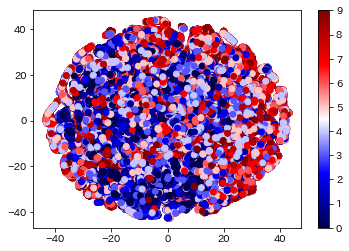

CPU times: user 3h 37min 40s, sys: 12min 7s, total: 3h 49min 48s
Wall time: 23min 59s


In [16]:
%%time
# 10min
tsne = TSNE()
x_embedded = tsne.fit_transform(X)
sc = plt.scatter(x_embedded[:, 0], x_embedded[:, 1], c=dataset_df["label"].values, cmap=cm.seismic)
plt.colorbar(sc)
plt.show()

/home/inui/anaconda3/envs/compound/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Train Mean Squared Error: 184.40363646025494
Test Mean Squared Error: 290.567420074164
CPU times: user 10h 49min, sys: 11min 4s, total: 11h 4s
Wall time: 28min 32s


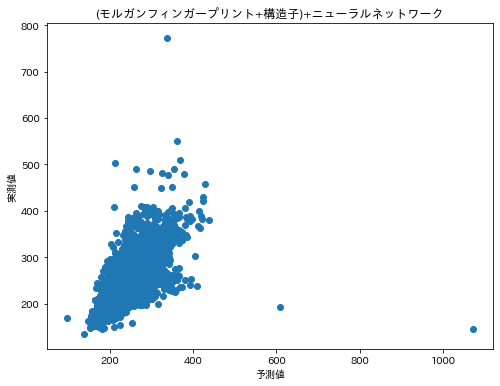

In [17]:
%%time
# 10min
title = "(モルガンフィンガープリント+構造子)+ニューラルネットワーク"
x_label = "予測値"
y_label = "実測値"

# 次元削減
# reducer = PCA(n_components=20)
# reducer.fit(X_train, y_train)
# X_train, X_test = reducer.transform(X_train), reducer.transform(X_test)

# 回帰モデル
model = MLPRegressor(hidden_layer_sizes=(100,100,))
model.fit(X_train, y_train)

# 予測
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(pred_test, y_test)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title(title)

print(f"Train Mean Squared Error: {mse(y_train, pred_train)}")
print(f"Test Mean Squared Error: {mse(y_test, pred_test)}")